In [1]:
from collections import defaultdict

import pandas as pd
import numpy as np
import scipy.stats as ss

import lightfm
import lightfm.data as ld
import lightfm.evaluation as lv

import tqdm
import json
import optuna

import tensorboardX as tb

import matplotlib.pyplot as pl
import seaborn as sns

np.random.seed(31337)

In [2]:
DATA_DIR = "data/"

In [3]:
data = pd.concat([
    pd.read_json(DATA_DIR + "data_1.json", lines=True),
    pd.read_json(DATA_DIR + "data_2.json", lines=True),
    pd.read_json(DATA_DIR + "data_3.json", lines=True),
    pd.read_json(DATA_DIR + "data_4.json", lines=True),
]).drop_duplicates(subset=["user", "track"])

In [4]:
positives = data[data["time"] > 0.8].copy()
positives["test"] = np.random.random(len(positives)) >= 0.7

In [5]:
user_counts = positives[~positives["test"]].groupby("user").size()
users = set(user_counts[user_counts >= 5].index.values)

In [6]:
track_counts = positives[~positives["test"]].groupby("track").size()
tracks = set(track_counts[track_counts >= 5].index.values)

## Train LightFM

In [7]:
train_data = positives[~positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]
test_data = positives[positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]

len(train_data), len(test_data)

(176969, 70154)

In [8]:
dataset = ld.Dataset()
dataset.fit(users, tracks)

In [9]:
train_interactions, _ = dataset.build_interactions(train_data[["user", "track"]].itertuples(index=False, name=None))
test_interactions, _ = dataset.build_interactions(test_data[["user", "track"]].itertuples(index=False, name=None))

In [10]:
def fit_model(epochs=1, at=10, loss="warp", no_components=30, learning_rate=0.01, max_sampled=10, user_alpha=0.0, item_alpha=0.0, threads=30, verbose=False):
    model = lightfm.LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=item_alpha,
    )

    precisions_at = []
    
    for epoch in range(epochs):
        model = model.fit_partial(train_interactions, num_threads=threads)
        precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=at, num_threads=threads)
        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
        precisions_at.append(np.mean(precision_at))
        
    return model, precisions_at


def objective(trial):
    loss = trial.suggest_categorical("loss", ["warp", "bpr"])
    no_components = trial.suggest_categorical("no_components", [10, 30, 50])
    learning_rate = trial.suggest_categorical("learning_rate", [0.0001, 0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.0001])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.0001])
    
    model, precisions_at = fit_model(
        epochs=5, 
        at=10,
        loss=loss,
        no_components=no_components, 
        learning_rate=learning_rate, 
        max_sampled=max_sampled, 
        user_alpha=user_alpha, 
        item_alpha=item_alpha,
    )
    
    return precisions_at[-1]

In [12]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
best_params = study.best_params

[I 2022-04-03 17:43:50,230] A new study created in memory with name: no-name-03801de1-83dc-406c-874d-2f69f3769277
[I 2022-04-03 17:43:56,276] Trial 0 finished with value: 0.0252271369099617 and parameters: {'loss': 'warp', 'no_components': 30, 'learning_rate': 0.001, 'max_sampled': 10, 'user_alpha': 0.0001, 'item_alpha': 0.0}. Best is trial 0 with value: 0.0252271369099617.
[I 2022-04-03 17:44:02,149] Trial 1 finished with value: 0.025247326120734215 and parameters: {'loss': 'warp', 'no_components': 30, 'learning_rate': 0.001, 'max_sampled': 20, 'user_alpha': 0.0, 'item_alpha': 0.0001}. Best is trial 1 with value: 0.025247326120734215.
[I 2022-04-03 17:44:05,442] Trial 2 finished with value: 0.026065008714795113 and parameters: {'loss': 'warp', 'no_components': 10, 'learning_rate': 0.01, 'max_sampled': 10, 'user_alpha': 0.0001, 'item_alpha': 0.0}. Best is trial 2 with value: 0.026065008714795113.
[I 2022-04-03 17:44:08,942] Trial 3 finished with value: 0.0035937814973294735 and paramet

In [18]:
model, precisions_at = fit_model(
    epochs=400,
    at=10,
    loss=best_params["loss"],
    no_components=best_params["no_components"], 
    learning_rate=best_params["learning_rate"], 
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    verbose=True,
)

0:	0.02532808482646942 +/- 0.0014052269379097114
1:	0.025873206555843353 +/- 0.0014180339138583286
2:	0.026539471000432968 +/- 0.0014357879358511394
3:	0.027508582919836044 +/- 0.0014694940795351703
4:	0.02782152220606804 +/- 0.0014785050482691666
5:	0.028295984491705894 +/- 0.0014891419969023756
6:	0.029093479737639427 +/- 0.0015198062875571266
7:	0.029366040602326393 +/- 0.0015332988982349465
8:	0.02973955310881138 +/- 0.001539304694590701
9:	0.030123159289360046 +/- 0.0015420049773975147
10:	0.031061984598636627 +/- 0.0015793962060074275
11:	0.0315566323697567 +/- 0.0015868547028668914
12:	0.03250555321574211 +/- 0.0016096104984352445
13:	0.03303048759698868 +/- 0.0016248530696127853
14:	0.03387845680117607 +/- 0.0016468479617560063
15:	0.034736521542072296 +/- 0.0016707666806848685
16:	0.03511003777384758 +/- 0.001685599749074221
17:	0.03563496842980385 +/- 0.0017012305482623478
18:	0.03616999834775925 +/- 0.0017196506908780087
19:	0.036412276327610016 +/- 0.001726079781946742
20:	

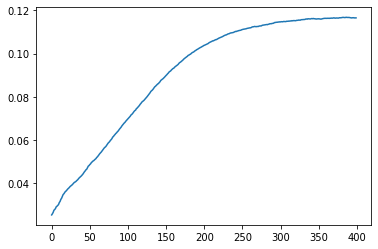

In [19]:
figure, ax = pl.subplots()

ax.plot(np.arange(len(precisions_at)), precisions_at)

pass

## Save track embeddings

In [21]:
biases, embeddings = model.get_item_representations()

In [22]:
model.item_biases *= 0.0

In [34]:
OTHER_DATA_DIR = "../botify/data/"
track_meta = pd.read_json(OTHER_DATA_DIR + "tracks.json", lines=True)
track_meta["dataset_index"] = track_meta["track"].map(lambda t: dataset.mapping()[2].get(t))

In [26]:
dataset_tracks = track_meta[pd.notnull(track_meta["dataset_index"])].sort_values("dataset_index")

In [29]:
DATA_DIR = "data/"
writer = tb.SummaryWriter(comment='msd_ligtfm_embeddings', log_dir=DATA_DIR + "tb")
writer.add_embedding(embeddings, metadata=list(dataset_tracks[["artist", "title"]].itertuples(index=False, name=None)), tag="lightfm", metadata_header=["artist", "title"])
writer.close()

## Compute top recommendations for artist

In [90]:
artists_and_tracks = dict()

for artist in dataset_tracks.artist:
    if artist not in artists_and_tracks.items():
        artists_and_tracks[artist] = list(dataset_tracks[dataset_tracks["artist"] == artist].track)

In [126]:
def neighbours_of_neighbours(artist) :
    embeddings_of_artist = list(embeddings[int(dataset_tracks[dataset_tracks["track"] == int(j)].dataset_index)] for j in artists_and_tracks[artist])
    neighbours = []
    for i in range(len(dataset_tracks)):
        if dataset_tracks.iloc[i].artist != artist:
            embedding = embeddings[int(dataset_tracks.iloc[i].dataset_index)]
            dist = sum(-np.dot(embeddings_of_artist, embedding))
            neighbours.append(dist)
    return np.argsort(neighbours)

In [136]:
k = 50

with open(OTHER_DATA_DIR + f"recommendations_for_artist_{k}.json", "w") as rf:
    for artist in artists_and_tracks:
        recommendations = []
        neighbours = neighbours_of_neighbours(artist)

        for neighbour in neighbours:
            recommended_track = dataset_tracks[dataset_tracks["dataset_index"] == neighbour].iloc[0]
            recommendation = int(recommended_track["track"])
            recommendations.append(recommendation)

            if len(recommendations) == k:
                break

        track_with_recommendations = dict()
        track_with_recommendations["artist"] = artist
        track_with_recommendations["recommendations"] = recommendations

        rf.write(json.dumps(track_with_recommendations) + "\n")

## Compute track popularity

In [32]:
track_popularity = (
    data
    .groupby("track")["time"]
    .sum()
    .to_frame()
    .sort_values("time", ascending=False)
    .reset_index()
)

track_popularity.head()

,track,time
0,177,842.73
1,171,787.22
2,176,783.38
3,424,748.29
4,246,743.81


In [35]:
with open(OTHER_DATA_DIR + "top_tracks.json", "w") as top_tracks_file:
    json.dump(track_popularity["track"].tolist(), top_tracks_file)

### Personal Top

In [137]:
max_person = max(data.user)

with open(OTHER_DATA_DIR + f"recommendations_for_users_{k}.json", "w") as rf:
    for user in range(max_person):
        user_data = data[(data["user"] == user) & (data["time"] > 0.4)].copy()
        track_popularity = (
            user_data
            .groupby("track")["time"]
            .sum()
            .to_frame()
            .sort_values("time", ascending=False)
            .reset_index()
        )
        recommendations = track_popularity["track"].head(k).tolist()

        track_with_recommendations = dict()
        track_with_recommendations["user"] = user
        track_with_recommendations["recommendations"] = recommendations

        rf.write(json.dumps(track_with_recommendations) + "\n")